# 1. Preparation

In [3]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
# Unzip the datasource file
!sudo apt-get update
!sudo apt-get install wget
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7" -O data.zip && rm -rf /tmp/cookies.txt
from zipfile import ZipFile
with ZipFile('./gdrive/My Drive/acse-miniproject.zip', 'r') as zipObj:
    print("Started unzipping... \n")
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
    print("Files unziped sucessfully\n")
!ls

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [92.1 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Pa

In [5]:
# install required packages
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 552kB 7.0MB/s 
Populating the interactive namespace from numpy and matplotlib


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import glob
import pandas as pd
import json 
import torch
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import csv

from google.colab import files
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset 
from torch.autograd import Variable
from __future__ import print_function, division
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from psutil import virtual_memory
from livelossplot import PlotLosses
from pycm import *
from PIL import Image

plt.ion()

In [34]:
# To check the situation of the GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu May 21 22:39:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    31W / 250W |  16161MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [35]:
# To check the amount of the available RAM
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [36]:
# To check if the notebook is working on GPU
device = torch.device("cuda:0")
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [0]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

# 2. Training Data Pre-processing

In [0]:
# Load the data from the files
with open("./mapping.json",'r', encoding='UTF-8') as f:
     load_dict = json.load(f)
train_file = glob.glob('./train/*/images/*.JPEG')
train_data = []
labels = []
count = 0

for f in train_file:
    img = np.array(Image.open(f))
    label_name = f.split('/')[2]
    label = load_dict.get(label_name)
    if img.shape != (64,64,3):
        img = np.stack((img,)*3, axis=-1)
    
    train_data.append(img)
    labels.append(label)
    count += 1

# Convert the traindata and labels to nparray    
train_data = np.array(train_data)
labels = np.array(labels)

In [40]:
# Calculate the mean and std of the datdaset
mean = train_data.mean(axis=(0,1,2))/255
std = train_data.std(axis=(0,1,2))/255
print(mean)
print(std)

[0.48024579 0.44807218 0.39754775]
[0.27698641 0.26906449 0.28208191]


In [46]:
# Create a 90-10 training and validation split
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(train_data, labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

print(len(indices[0]))
print(len(indices[1]))

90000
10000


In [47]:
# Instantiate the datasets
X_train, y_train = torch.tensor(train_data[indices[0]]).float(), torch.tensor(labels)[indices[0]]
X_val, y_val = torch.tensor(train_data[indices[1]]).float(), torch.tensor(labels)[indices[1]]

# Reshape the dataset
X_train = X_train.permute(0,3,1,2)
X_val = X_val.permute(0,3,1,2)

print(X_train.size())
print(X_val.size())
print(y_train.size())

torch.Size([90000, 3, 64, 64])
torch.Size([10000, 3, 64, 64])
torch.Size([90000])


# 3. Data augmentation

In [0]:
# Define a custom datasets and transforms
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [0]:
# Define the transform for Data-augmentation and instantiate two CustomImageTensorDatasets
train_transform = torchvision.transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

valid_transform = torchvision.transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

train_set = CustomImageTensorDataset(X_train, y_train.long(), transform=train_transform)
valid_set = CustomImageTensorDataset(X_val, y_val.long(), transform=valid_transform)

# 4. Train, Validation and Evaluate Functions

In [0]:
# Define the train, validate and evaluate functions
def train(model, optimizer, criterion, data_loader):
    """
    Train a single epoch
    """
    model.train() # the model is in the training mode so the parameters(weights)to be optimised will be updatad at each step
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 224, 224))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) ## .cpu cpoies the tensor to the cpu to evaluate the accuracy score since it is a scikitlearn metric which does not run on GPUs
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)  ## loss and accuracy calculated give the total for all batches and must be divided by the number of batch size to give the average values.

def validate(model, criterion, data_loader):
    """
    Find the loss and accuracy of the current model parameters to the
    validation data set
    """
    model.eval() ## model is set to evaluation mode to freeze the parameters and ensure weights are not updated at each step so that the trained model is used to evaluate the validation loss
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    """
    Find the prediction of the current model parameters with the test
    data set and return both the predicted and actual labels
    """
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

## 5. Perform the training of the network and validation

In [0]:
# Set the hyperparameters
seed = 42
lr = 0.01
momentum = 0.9
batch_size = 64
test_batch_size = 1000
n_epochs = 10
weight_decay = 2e-5

In [0]:
def exp_lr_scheduler(optimizer, epoch, lr_decay=0.1, lr_decay_epoch=2):
    """
    Decay learning rate by a factor of lr_decay every lr_decay_epoch epochs
    """
    if epoch % lr_decay_epoch :
        return optimizer
    if epoch >= 6:
        return optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay
    return optimizer

def train_model(model, criterion, optimizer, num_epochs):
    """
    Do a live plot of the training accuracy and loss as the model is trained
    """
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_loader = DataLoader(valid_set, batch_size=test_batch_size, shuffle=False, num_workers=0)
  
    liveloss = PlotLosses()
    for epoch in range(num_epochs):
        optimizer = exp_lr_scheduler(optimizer, epoch)
        logs = {}

        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, valid_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()

    return model

In [0]:
model_ft = models.resnet101(pretrained=True, progress=True)
 
if torch.cuda.is_available():
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()
 
# Observe that all parameters are being opt imized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

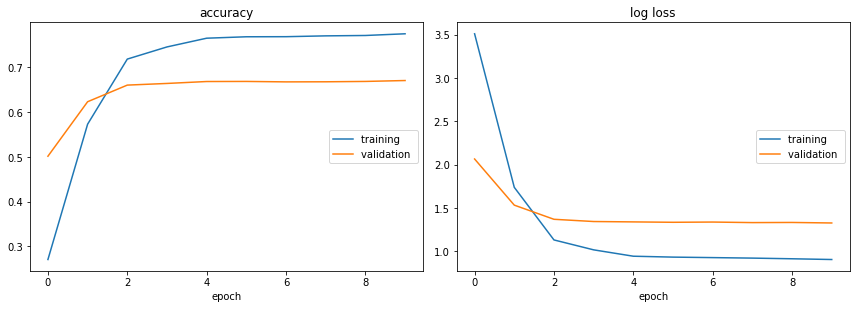

accuracy
	training         	 (min:    0.109, max:    0.775, cur:    0.775)
	validation       	 (min:    0.285, max:    0.670, cur:    0.670)
log loss
	training         	 (min:    0.907, max:    4.650, cur:    0.907)
	validation       	 (min:    1.329, max:    3.481, cur:    1.329)


In [55]:
# Perform the training and plot the accuracy and loss changes
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=n_epochs)

In [0]:
# Save the trained model
path = F"/content/gdrive/My Drive/models/Classifier.pth" 
torch.save(model_ft.state_dict(), path)

#6. Test the trained model on the test set

In [34]:
# Load the 
data_path='./test/'

test_transform = torchvision.transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])

test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=test_transform)

test_file = glob.glob('test/images/*.JPEG')
print(len(test_file))
test_data = []
test_names = []

for f in test_file:
    img = np.asarray(Image.open(f))
    test_name = f.split('/')[2][5:-5]
    #label = load_dict.get(label_name)
    if img.shape != (64,64,3):
        img = np.stack((img,)*3, axis=-1)

    test_data.append(img)
    test_names.append(int(test_name))

print(test_names[:5])

y_test = np.array(test_names) # y_test is only used for generating dataset. it's not the real labels
y_test = torch.tensor(y_test)
 
X_test = np.array(test_data)
X_test = torch.tensor(X_test).float()
X_test = X_test.permute(0,3,1,2)
 
test_set = CustomImageTensorDataset(X_test, y_test.long(), transform=valid_transform)

test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=1000,
        num_workers=0,
        shuffle=False
)

10000
[2188, 5321, 3946, 2657, 9941]


In [35]:
# Perform the evaluation
y_pred, y_gt = evaluate(model_ft, test_loader)
y_pred[:5], y_gt[:5]

(array([133,  50, 179, 193, 133]), array([2188, 5321, 3946, 2657, 9941]))

# 7. Post-processing for the prediction result

In [0]:
res = {}
for i in range(10000):
    res["test_" + str(y_gt[i]) + ".jpeg"] = y_pred[i]

with open('/content/gdrive/My Drive/Logistic/prediction.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Filename", "Label"])
    for key, item in res.items():
        writer.writerow([key, item])

# Download the prediction result        
files.download('/content/gdrive/My Drive/Logistic/prediction.csv')